In [ ]:
!pip install hashedindex
!pip install pygtrie
!pip install squarify
import nltk
nltk.download(['punkt','averaged_perceptron_tagger','wordnet', 'omw-1.4'])

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


[nltk_data] Downloading package punkt to /home/guillermo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/guillermo/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/guillermo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/guillermo/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, pos_tag
from nltk.corpus import wordnet
from nltk.corpus.reader.wordnet import NOUN, VERB, ADV, ADJ
from PIL import Image
from math import log
from collections import Counter
from hashedindex import textparser
import IPython.display as display 
import pandas as pd
import glob
import codecs
import re
import numpy as np
import hashedindex
import pygtrie
import squarify
import matplotlib.pyplot as plt

# Universidad Nacional Autónoma de México
## Instituto de Investigaciones en Matemáticas Aplicadas y en Sistemas
### Datos Masivos I. Miniproyecto II. Búsqueda de pares similares. 

**Integrantes**

- Nolasco Cabello Adrian Bruce
- Ayala Salcedo Marlene V
- Fuentes Cruz Ariel
- Andrés Urbano Guillermo Gerardo

## Dataset 

El Dataset asignado para este documento es el *Long Movie Review Dataset*. 

Este Dataset consiste en dos sub conjuntos; uno de entranamiento y otro de prueba. Cada uno cuenta con 25 mil reseñas largas de películas en formato *.txt*, las cuales han sido clasificadas binariamente en reseñas positivas y reseñas negativas, teniendo 12 mil 500 positivas y 12 mil 500 negativas.   

Posterior a la carga de datos se mostrará un ejemplo de reseña. 

## Carga de datos

Leemos el conjunto de archivos y almacenamos cada reseña en la variable `db` para posteriormente hacer el procesamiento.

In [ ]:
list_of_files = glob.glob('neg/*.txt')
db = []
labels = []
for file_name in list_of_files:
    f = open(file_name, 'r', encoding="utf8")
    text = f.read()
    db.append(text)
    labels.append(1)

In [ ]:
list_of_files2 = glob.glob('pos/*.txt')

for file_name in list_of_files2:
    f = open(file_name, 'r', encoding="utf8")
    text = f.read()
    db.append(text)
    labels.append(-1)

In [ ]:
print(f'Un ejemplo de reseña negativa en el dataset es; \n {db[0]}')

Un ejemplo de reseña negativa en el dataset es; 
 Once again Mr. Costner has dragged out a movie for far longer than necessary. Aside from the terrific sea rescue sequences, of which there are very few I just did not care about any of the characters. Most of us have ghosts in the closet, and Costner's character are realized early on, and then forgotten until much later, by which time I did not care. The character we should really care about is a very cocky, overconfident Ashton Kutcher. The problem is he comes off as kid who thinks he's better than anyone else around him and shows no signs of a cluttered closet. His only obstacle appears to be winning over Costner. Finally when we are well past the half way point of this stinker, Costner tells us all about Kutcher's ghosts. We are told why Kutcher is driven to be the best with no prior inkling or foreshadowing. No magic here, it was all I could do to keep from turning it off an hour in.


In [ ]:
print(f'Un ejemplo de reseña positiva en el dataset es; \n {db[12500]}')

Un ejemplo de reseña positiva en el dataset es; 
 I went and saw this movie last night after being coaxed to by a few friends of mine. I'll admit that I was reluctant to see it because from what I knew of Ashton Kutcher he was only able to do comedy. I was wrong. Kutcher played the character of Jake Fischer very well, and Kevin Costner played Ben Randall with such professionalism. The sign of a good movie is that it can toy with our emotions. This one did exactly that. The entire theater (which was sold out) was overcome by laughter during the first half of the movie, and were moved to tears during the second half. While exiting the theater I not only saw many women in tears, but many full grown men as well, trying desperately not to let anyone see them crying. This movie was great, and I suggest that you go see it before you judge.


In [ ]:
print("Total de reseñas negativas: {}".format(12500)) # 12500
print("Total de reseñas positivas: {}".format(len(db) - 12500))

Total de reseñas negativas: 12500
Total de reseñas positivas: 12500


## Preprocesamiento de datos

Debido a que el objetivo es buscar pares similares, el preprocesamiento incluirá, además de eliminar las stopwords desde una lista extendida de stopwords, un analizador léxico y un lematizador. Es decir, primero se encargará de transformar la secuencia de caracteres a una secuencia de tokens para posteriormente encontrar la raíz de las palabras cuando estas están en su forma flexionada. 

In [ ]:
!wget -qO- -O stopwords_english.txt \
         https://raw.githubusercontent.com/pan-webis-de/authorid/master/data/stopwords_english.txt

stopwords = []
for line in codecs.open('stopwords_english.txt', encoding = "utf-8"):
    # Eliminamos espacios a la derecha en caso de existir
    stopwords.append(line.rstrip())

In [ ]:
from nltk.stem import WordNetLemmatizer
#Lematizador y analizador léxico
morphy_tag = {'JJ' : ADJ,'JJR' : ADJ,'JJS' : ADJ,'VB'   : VERB,'VBD' : VERB,
              'VBG': VERB,'VBN': VERB,'VBP': VERB,'VBZ' : VERB, 'RB' : ADV,
              'RBR': ADV,'RBS' : ADV }

def doc_a_tokens(doc):
  tagged = pos_tag(word_tokenize(doc.lower()))
  lemmatizer = WordNetLemmatizer()
  tokens = []
  for p,t in tagged:
    tokens.append(lemmatizer.lemmatize(p, pos=morphy_tag.get(t, NOUN)))
  return tokens

### Optimización para filtrar las stopwords

Observemos que para indentificar si una palabra de una lista con longitud $n$ está en una lista de stopwords, con longitud $m$, debe de recorrer toda las lista, por lo que el tiempo de complejidad sería lineal para esa palabra, es decir, para $n$ palabras se tendría una complejidad $O(n*m)$. 

Para reducir el tiempo de comparación entre una palabra y alguna stopword, pensamos en ordenar la lista de las stopwords para posteriormente hacer una busqueda binaria y tener un tiempo de complejidad $O(log_2 (n))$, ahora para k palabras tendriamos un tiempo de complejidad al filtrar de $O(klog_2(n))$.

In [ ]:
from bisect import bisect

def binary_search(a,x,lo=0,hi=-1):
    i = bisect(a,x,lo,hi)
    if i == 0:
        return -1
    elif a[i-1] == x:
        return i-1
    else:
        return -1

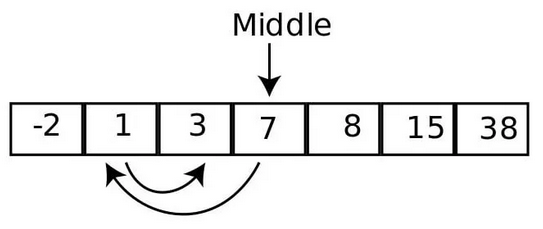

In [ ]:
display.display(Image.open('/work/DM-MiniProyectoII/img/binary.png'))

Otra práctica para reducir el tiempo de comparación entre una palabra y una lista de stepwords es crean un Trie; un árbol que almacena un conjunto de claves donde cada clave corresponde, en este caso, a una letra. Cada letra es colocada de tal forma que los nodos hijos representen las diferentes posibilidades de palabras a crear a partir del nodo padre. 

La busqueda más tardada es proporcional a la longitud maxima de la lista de las stopwords.

In [ ]:
class StopTrie():
    def __init__(self,stoplist):
        self.pset = pygtrie.PrefixSet()
        self.maxlen = 0
        for word in stoplist:
            #print(w)
            self.pset.add(word)
            if len(word) > self.maxlen:
                self.maxlen= len(word)
    
    def isin(self,word):
        if len(word)> self.maxlen:
            return False
        else:
            return word in self.pset

stopwords_trie = StopTrie(stopwords)

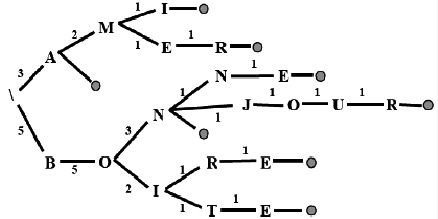

In [ ]:
display.display(Image.open('/work/DM-MiniProyectoII/img/index.jpg'))

# Indice Inverso

Para este proyecto se ha empleado el índice Inverso para generar el pequeño *motor de búsqueda*.

Para ello, utilizamos la librería de Hashed Index para hacer el hash de cada una de nuestras palabras en el documento.

In [ ]:
index = hashedindex.HashedIndex()
id_doc = 0
doc_dic = dict()
lab_dic = dict()

corpus = []
for d,l in zip(db,labels):
    doc_dic[id_doc] = d
    lab_dic[id_doc] = l
    # Removemos los posibles saltas de linea y tabulaciones
    d = d.replace('\n',' ').replace('\r',' ').replace('\t',' ')
    # Remueve etiquetas html
    d = re.sub(r'<.*?>', '', d)
    # Filtramos solo los caracteres alfanumericos, pasamos a minúsculas y se une para formar la oración.
    d = ' '.join([''.join([c.lower() for c in p if c.isalpha()]) for p in d.split()])    
    # Lematizamos nuestro documento
    tokens = doc_a_tokens(d)    
    
    tokens_sin_stopwords = []
    for t in tokens:
        indice = binary_search(stopwords, t)
        if indice == -1:
            index.add_term_occurrence(t, id_doc) 
            tokens_sin_stopwords.append(t)
            
    corpus.append(' '.join(tokens_sin_stopwords))
            
    id_doc += 1

A continuación mostramos nuestro hash con las palabras y su cuenta. En donde la primer entrada se refiere al número de documento y la segunda a la cantidad de veces que aparece la palabra en el correspondiente documento.

In [ ]:
#index.items()

{'mr': Counter({0: 1,
          42: 1,
          73: 1,
          90: 1,
          92: 1,
          126: 1,
          166: 1,
          179: 2,
          191: 1,
          247: 1,
          268: 1,
          281: 1,
          285: 2,
          302: 1,
          333: 1,
          348: 3,
          368: 2,
          371: 1,
          393: 1,
          403: 1,
          453: 1,
          492: 1,
          502: 1,
          600: 1,
          642: 1,
          661: 1,
          671: 2,
          751: 1,
          770: 2,
          831: 1,
          857: 1,
          872: 1,
          972: 1,
          1041: 1,
          1095: 1,
          1141: 2,
          1200: 1,
          1245: 1,
          1253: 1,
          1254: 1,
          1291: 2,
          1292: 4,
          1293: 4,
          1294: 3,
          1313: 1,
          1314: 1,
          1431: 1,
          1468: 1,
          1479: 1,
          1484: 2,
          1506: 1,
          1511: 1,
          1514: 1,
          1535: 1,
       

##  Distribución de frecuencias


In [ ]:
# Obtenemos las frecuencias de cada palabra.
frecuencies =  list(map(lambda term: (term, index.get_total_term_frequency(term)) ,index.items()))

# Guardamos los datos en un diccionario para un mejor manejo,
freq_dic = dict(
    palabras=list(map(lambda pair: pair[0], frecuencies)),
    frecuencias=list(map(lambda pair: pair[1], frecuencies))
)

In [ ]:
print(f"Así se tiene que el vocabulario total es de: {len(freq_dic['frecuencias'])} palabras")

~~~
Así se tiene que el vocabulario total es de: 123865 palabras
~~~

### Top 15 de las palabras en común de todas las reseñas

Aprovechando que tenemos las frecuencias de la palabras podemos conocer el top 15 de las palabras en común de todas reseñas.

<AxesSubplot:>

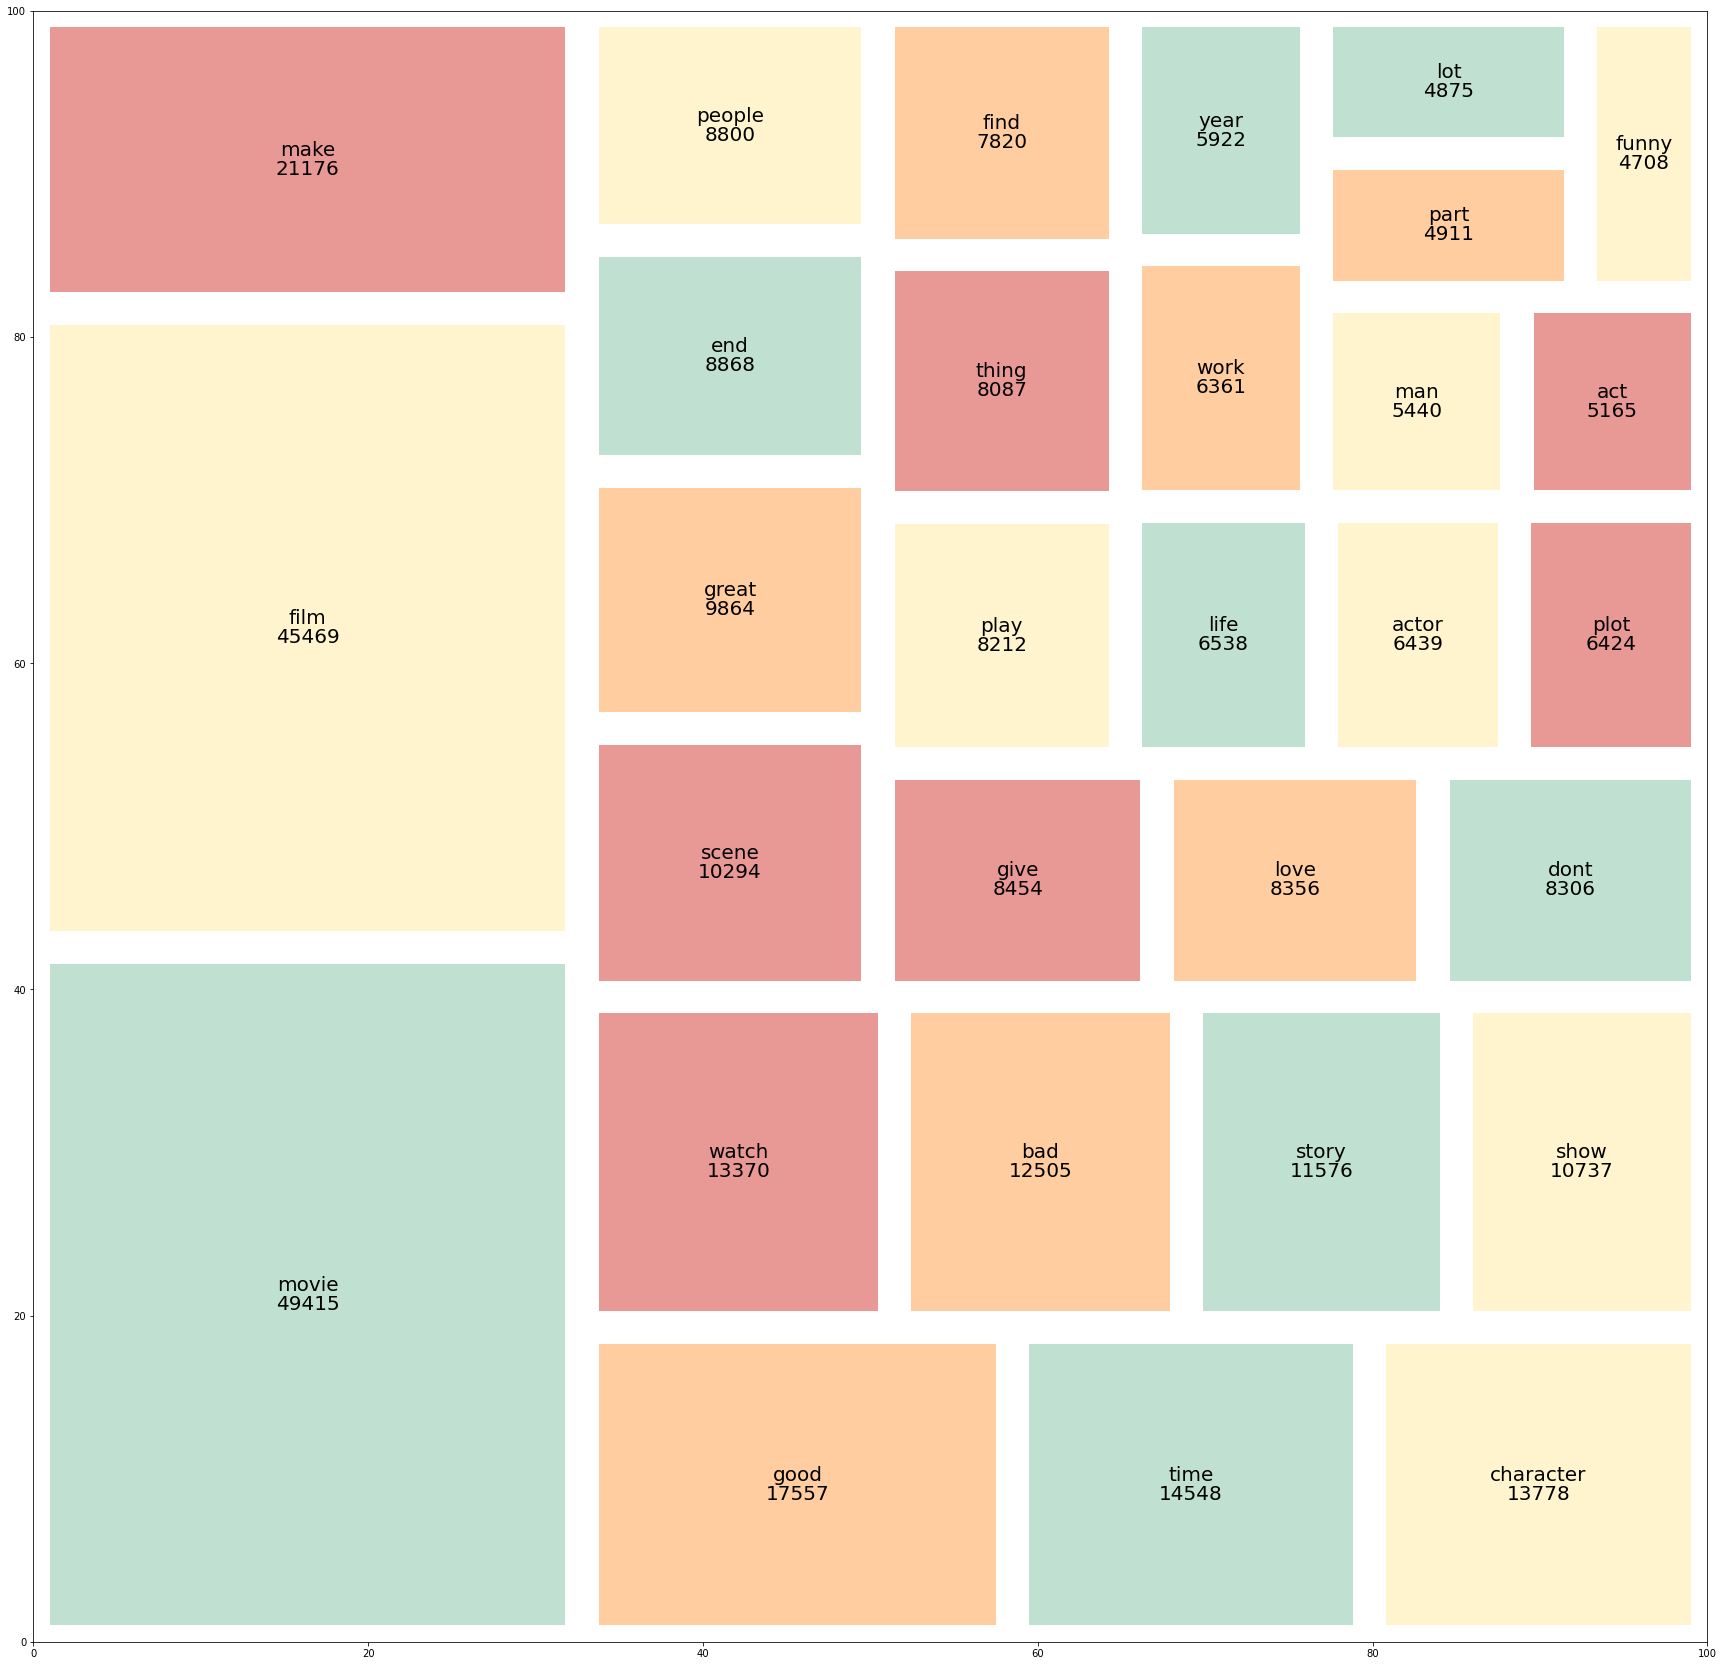

In [ ]:
# Obtenemos top 15 de las palabras más en común
top15 = sorted(frecuencies, key=lambda pair: pair[1], reverse=True)[:30]

# Visualización de las palabras
fig, axes = plt.subplots(1,1, figsize=(30,30))
label = list(map(lambda pair: pair[0], top15))
size = list(map(lambda pair: pair[1], top15))
colors = []'#96CEB4', '#FFEEAD', '#D9534F', '#FFAD60'

squarify.plot(sizes=size, label=label, alpha=0.6, pad = True, color=colors, value=size, text_kwargs={'fontsize':20})

## Reseñas Positivas

### Bigramas

<AxesSubplot:>

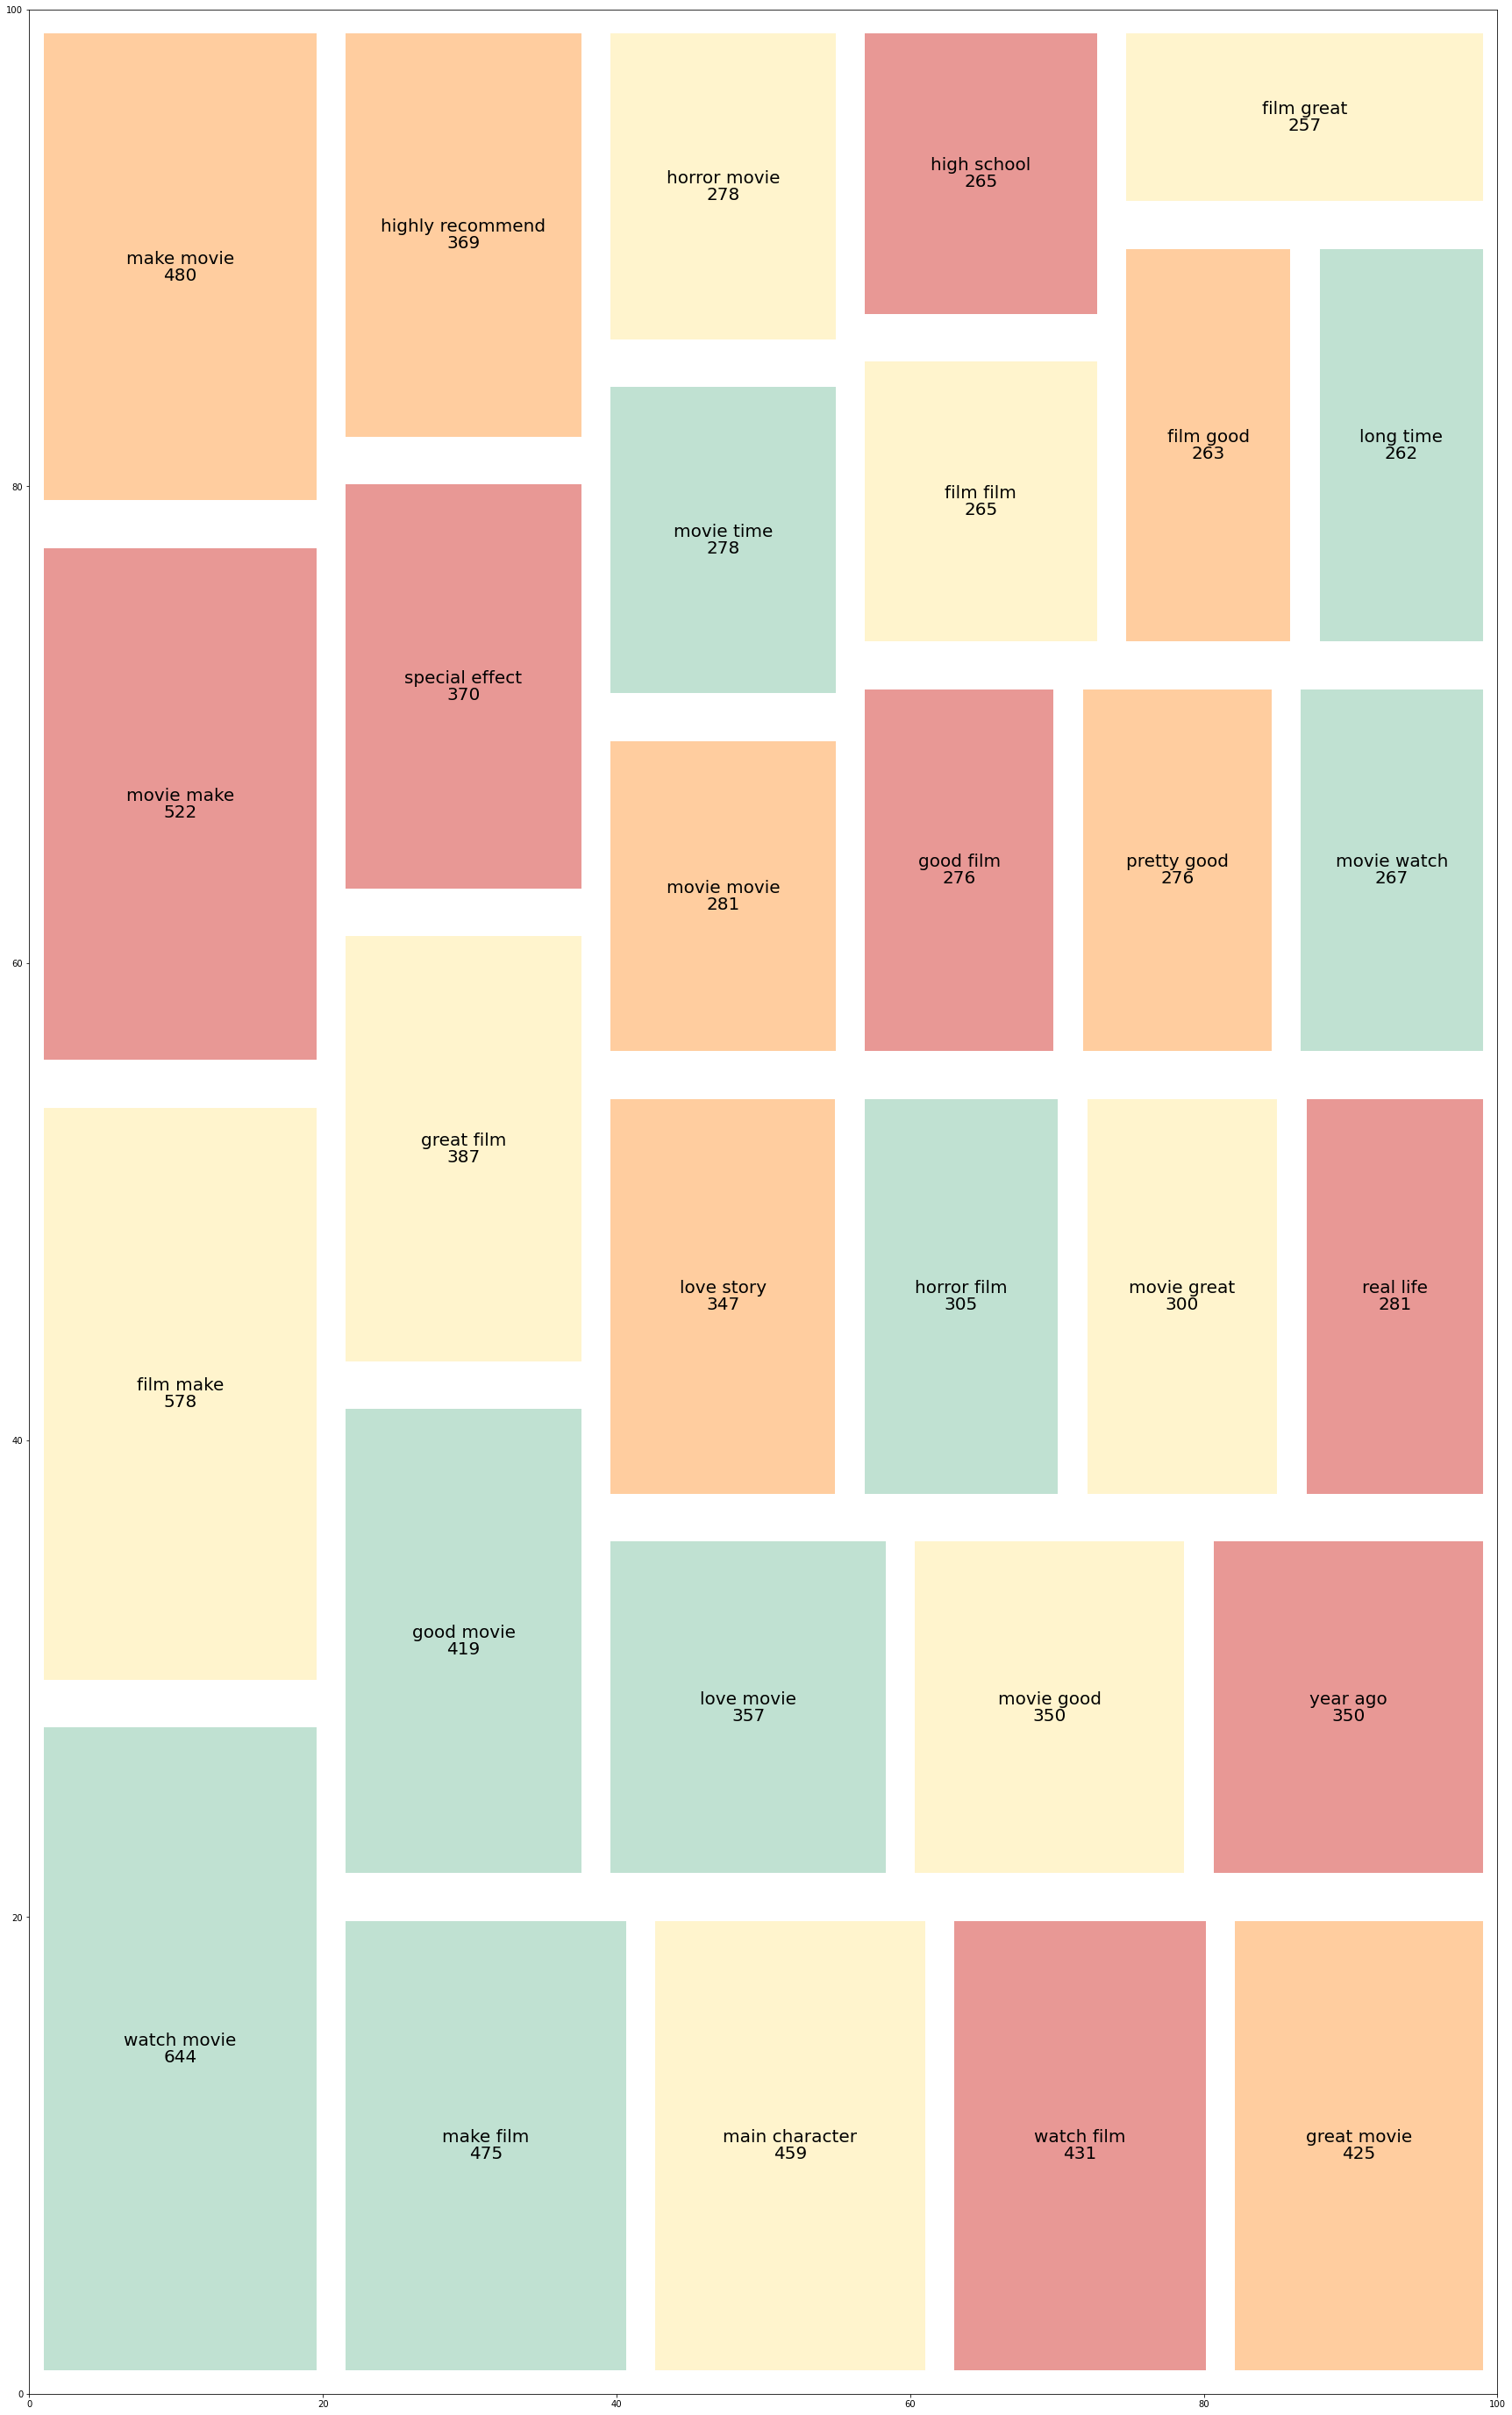

In [ ]:
from hashedindex import textparser

bigramas = []
for c in corpus[12500:]:
    bigramas.append(textparser.word_tokenize(c, ngrams=2))
    
tmp = []
for l in bigramas:
    tmp.extend(l)      
    
# Contando las frecuencias    
counter = dict()
for f in tmp:
    if f not in counter:
        counter[f] = 1
    else:
        counter[f] += 1
bigramas_freq = list(zip(counter.keys(), counter.values()))    

# Obtenemos top 15 de las palabras más en común
top15 = sorted(bigramas_freq, key=lambda pair: pair[1], reverse=True)[:30]

fig, axes = plt.subplots(1,1, figsize=(30,50))
label = list(map(lambda pair:  ' '.join(pair[0]), top15))
size = list(map(lambda pair: pair[1], top15))
colors = ['#96CEB4', '#FFEEAD', '#D9534F', '#FFAD60']

squarify.plot(sizes=size, label=label, alpha=0.6, pad = True, color=colors, value=size, text_kwargs={'fontsize':20})

## Trigramas

<AxesSubplot:>

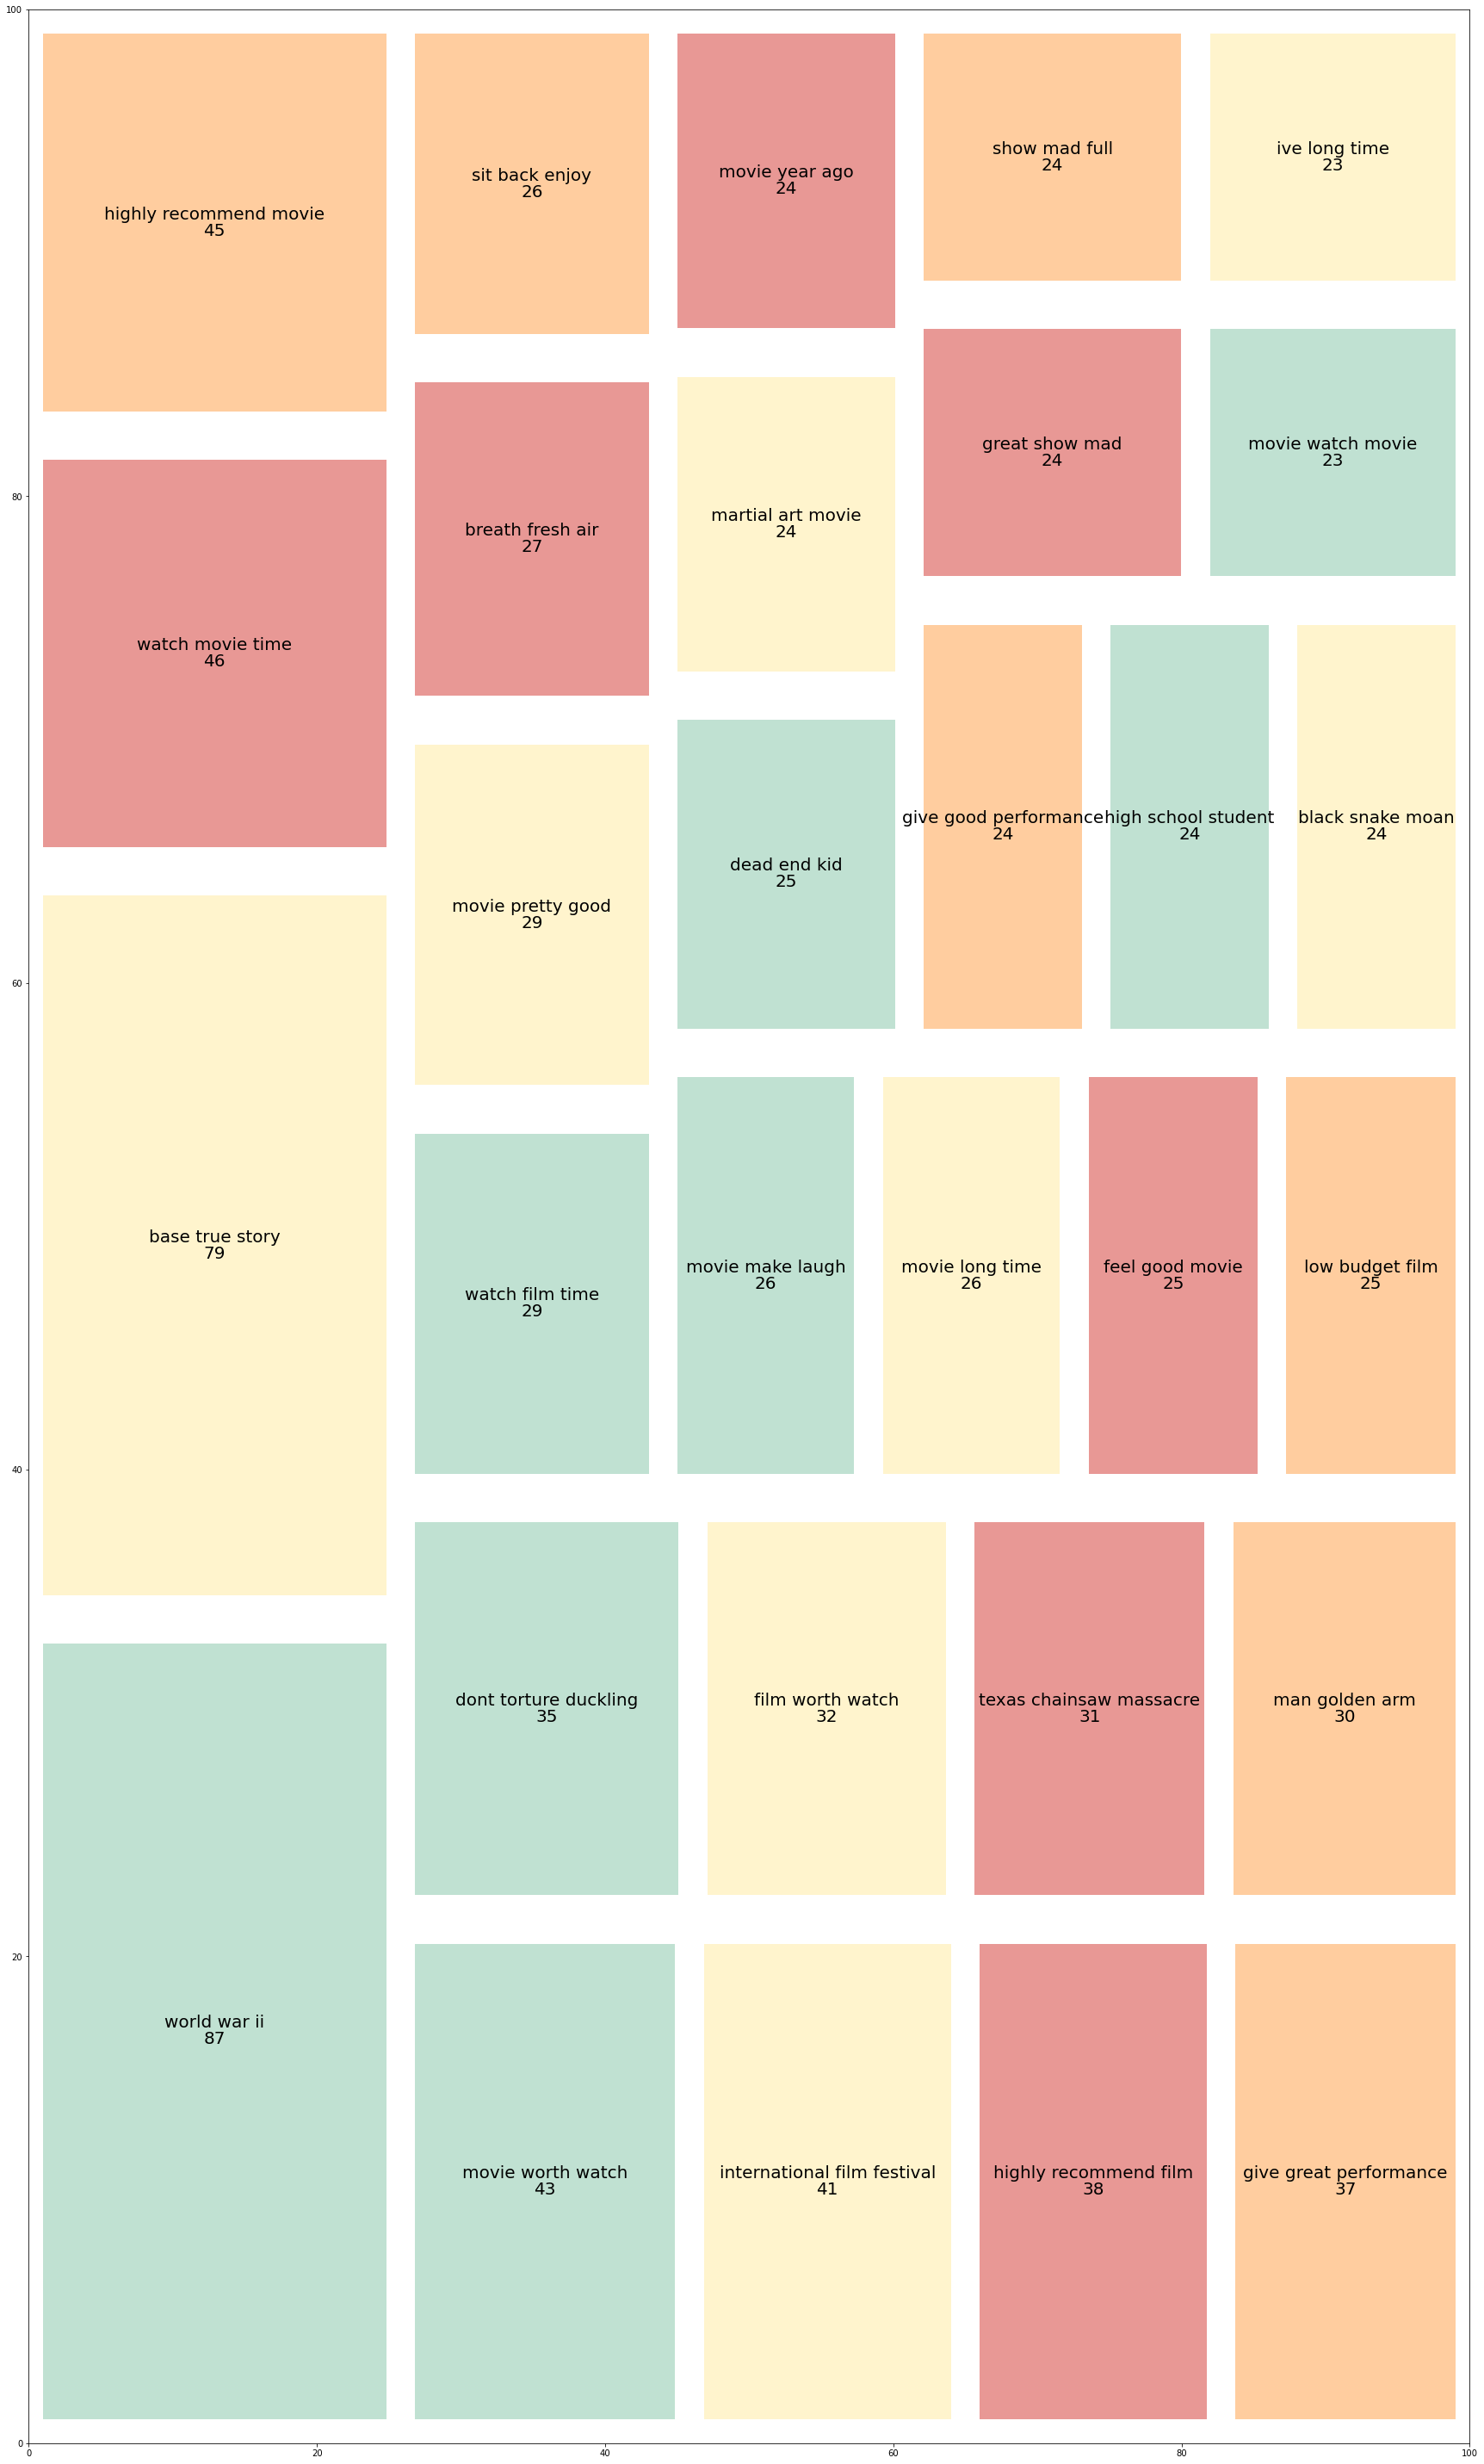

In [ ]:
from hashedindex import textparser

bigramas = []
for c in corpus[12500:]:
    bigramas.append(textparser.word_tokenize(c, ngrams=3))
    
tmp = []
for l in bigramas:
    tmp.extend(l)      
    
# Contando las frecuencias    
counter = dict()
for f in tmp:
    if f not in counter:
        counter[f] = 1
    else:
        counter[f] += 1
trigramas_freq = list(zip(counter.keys(), counter.values()))

# Obtenemos top 15 de las palabras más en común
top15 = sorted(trigramas_freq, key=lambda pair: pair[1], reverse=True)[:30]

fig, axes = plt.subplots(1,1, figsize=(30,50))
label = list(map(lambda pair: ' '.join(pair[0]), top15))
size = list(map(lambda pair: pair[1], top15))
colors = ['#96CEB4', '#FFEEAD', '#D9534F', '#FFAD60']

squarify.plot(sizes=size, label=label, alpha=0.6, pad = True, color=colors, value=size, text_kwargs={'fontsize':20})

## Reseñas Negativas

### Bigramas

<AxesSubplot:>

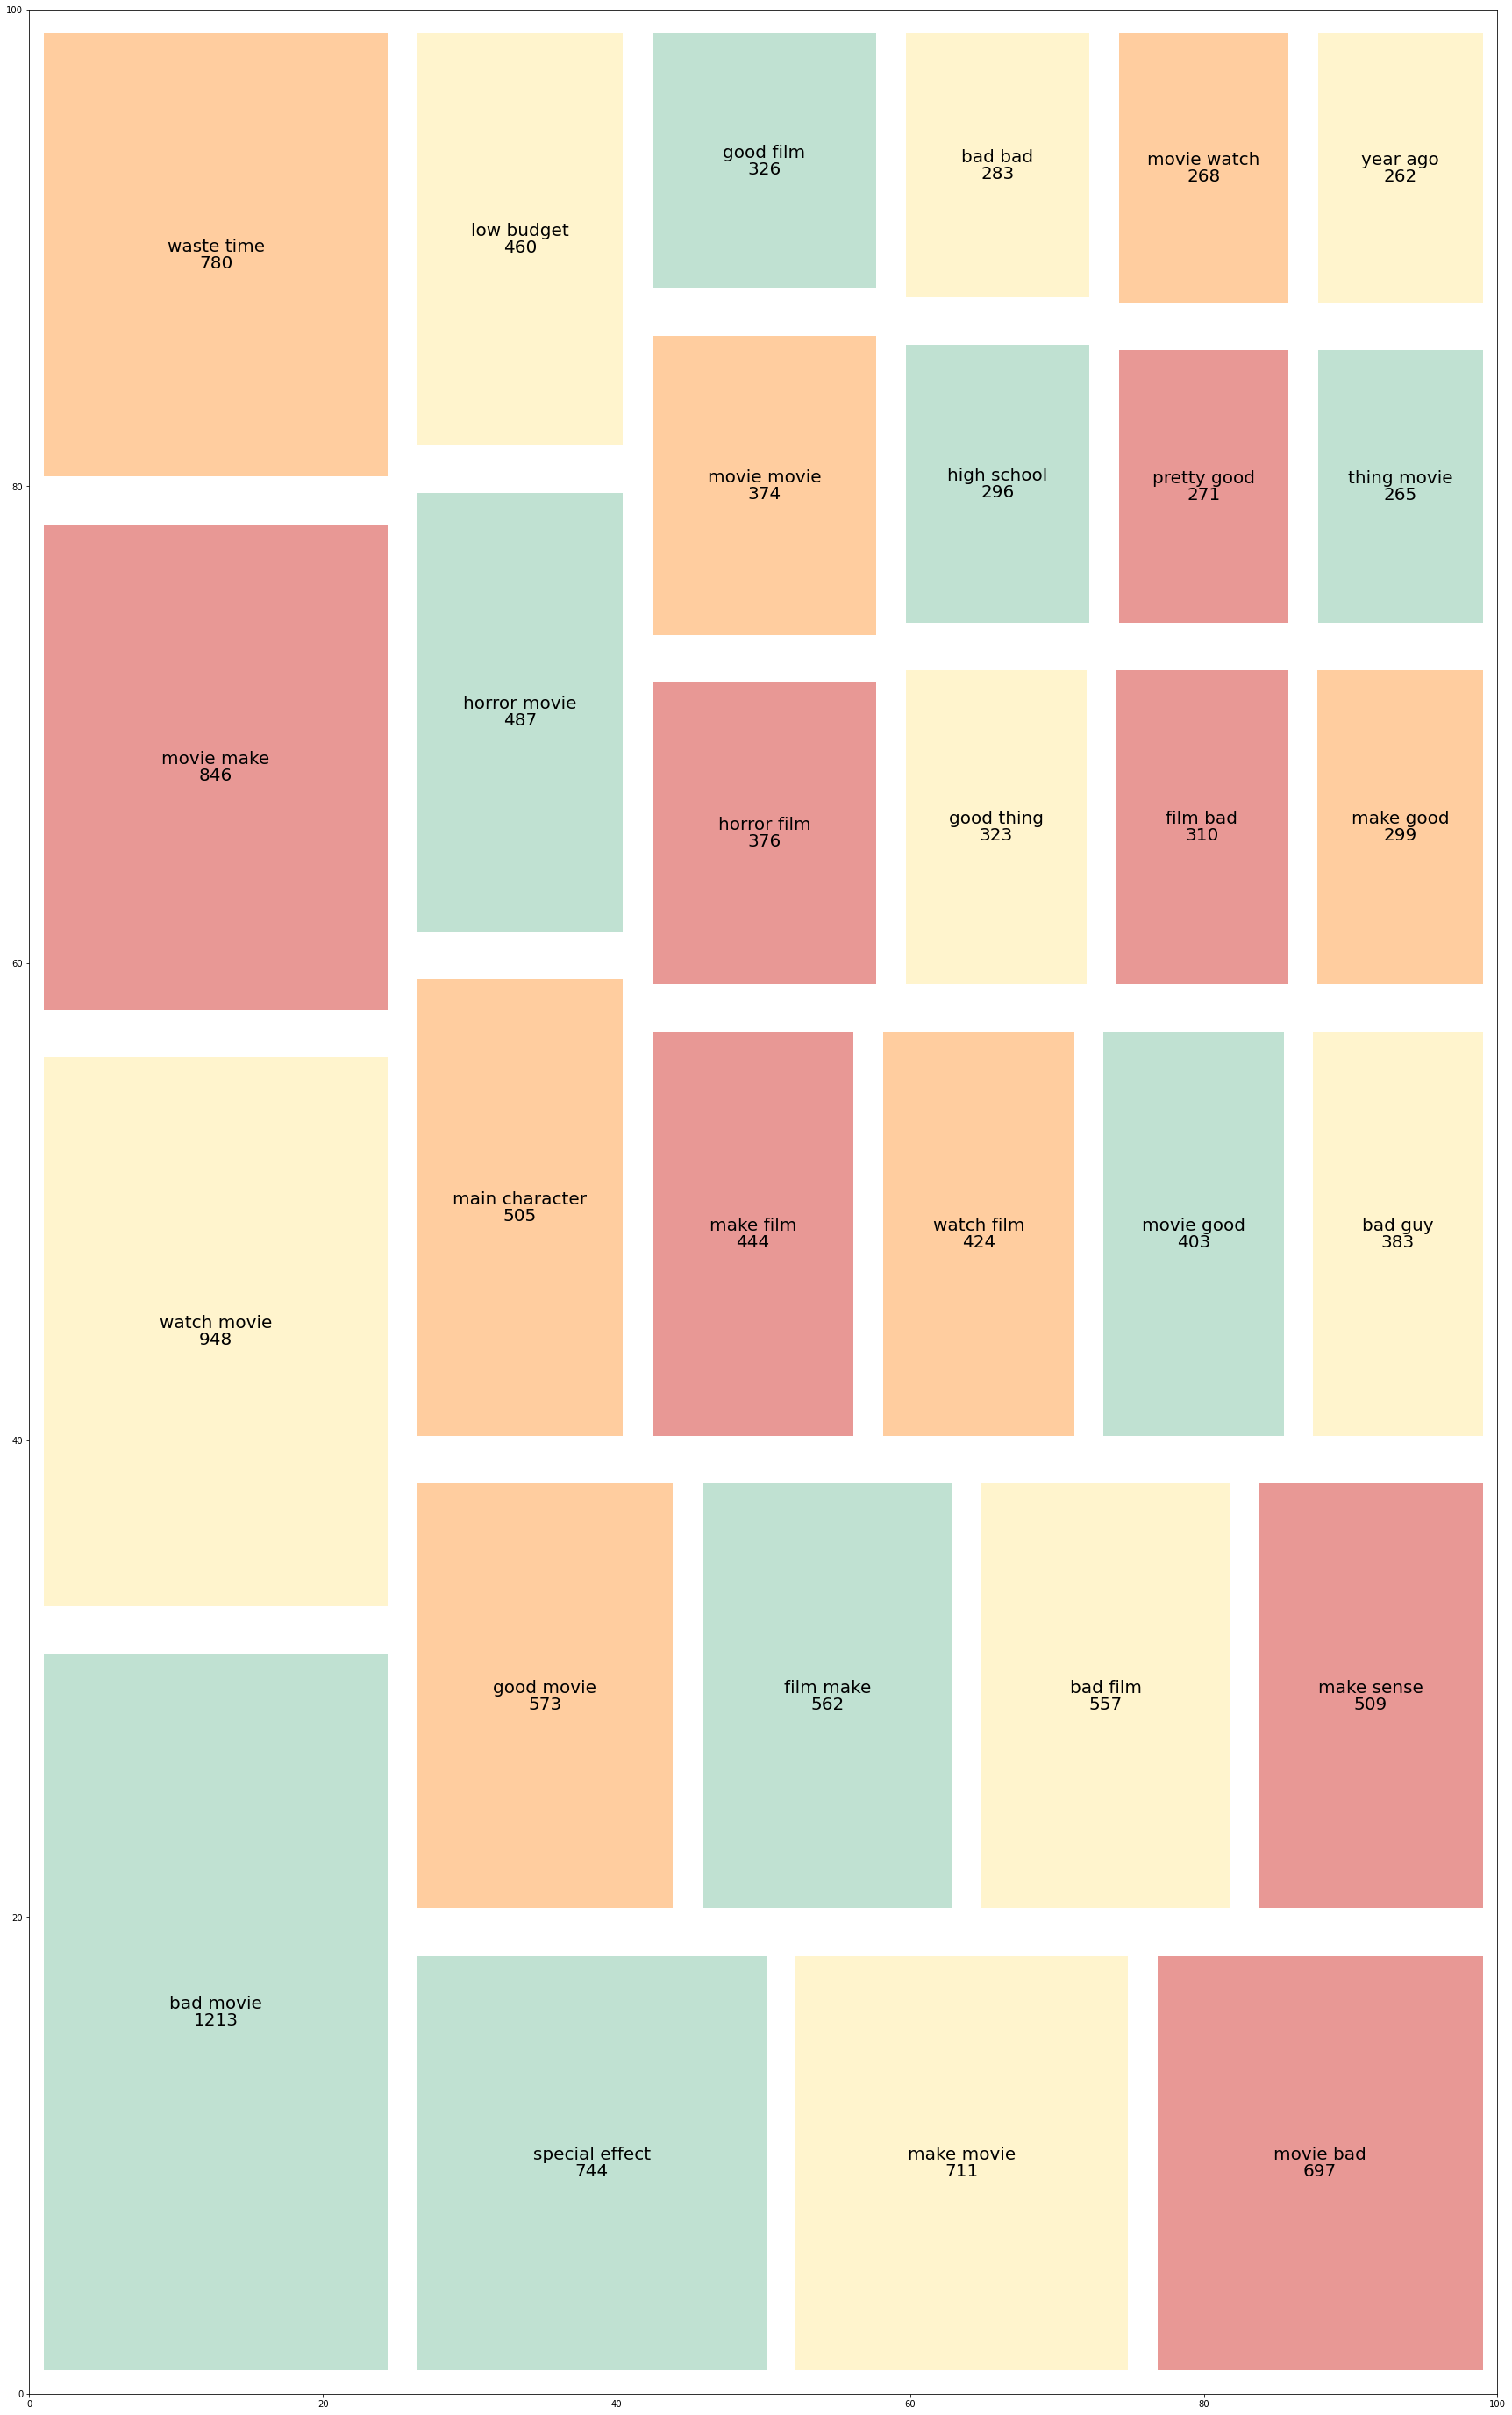

In [ ]:
from hashedindex import textparser

bigramas = []
for c in corpus[:12500]:
    bigramas.append(textparser.word_tokenize(c, ngrams=2))
    
tmp = []
for l in bigramas:
    tmp.extend(l)      
    
# Contando las frecuencias    
counter = dict()
for f in tmp:
    if f not in counter:
        counter[f] = 1
    else:
        counter[f] += 1
bigramas_freq = list(zip(counter.keys(), counter.values()))    

# Obtenemos top 15 de las palabras más en común
top15 = sorted(bigramas_freq, key=lambda pair: pair[1], reverse=True)[:30]

fig, axes = plt.subplots(1,1, figsize=(30,50))
label = list(map(lambda pair: ' '.join(pair[0]), top15))
size = list(map(lambda pair: pair[1], top15))
colors = ['#96CEB4', '#FFEEAD', '#D9534F', '#FFAD60']

squarify.plot(sizes=size, label=label, alpha=0.6, pad = True, color=colors, value=size, text_kwargs={'fontsize':20})

## Trigramas

<AxesSubplot:>

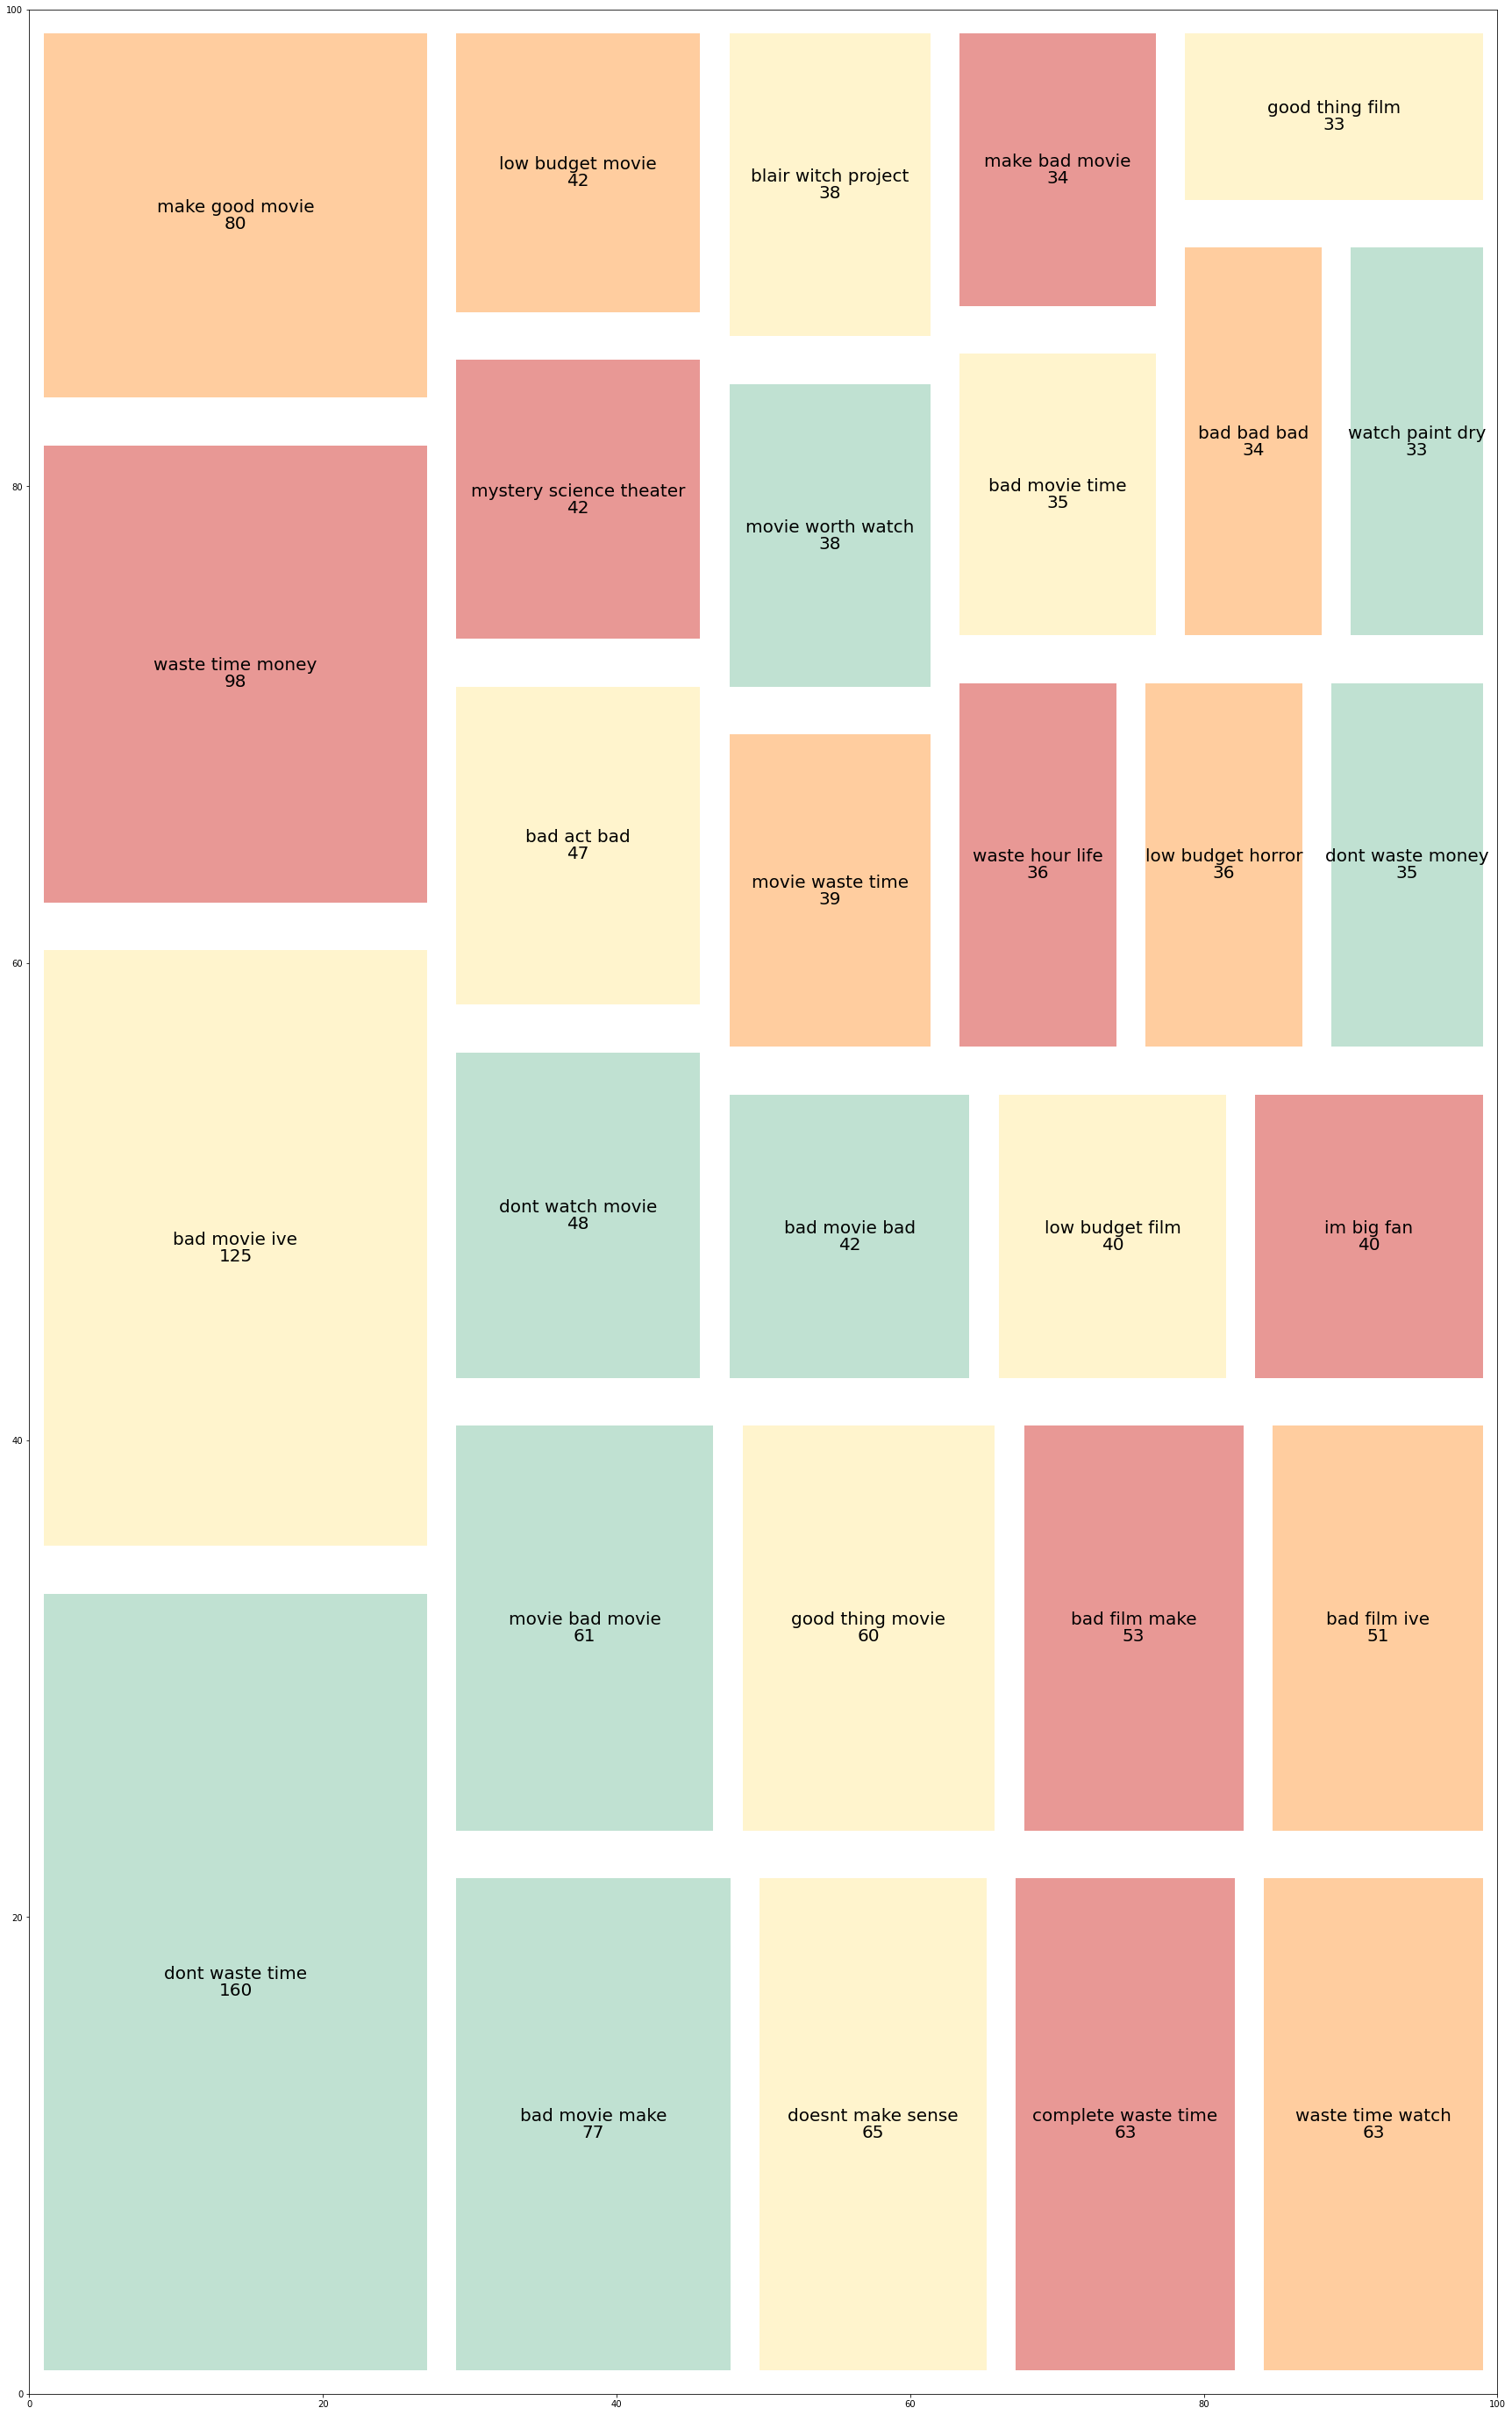

In [ ]:
from hashedindex import textparser

bigramas = []
for c in corpus[:12500]:
    bigramas.append(textparser.word_tokenize(c, ngrams=3))
    
tmp = []
for l in bigramas:
    tmp.extend(l)      
    
# Contando las frecuencias    
counter = dict()
for f in tmp:
    if f not in counter:
        counter[f] = 1
    else:
        counter[f] += 1
trigramas_freq = list(zip(counter.keys(), counter.values()))

# Obtenemos top 15 de las palabras más en común
top15 = sorted(trigramas_freq, key=lambda pair: pair[1], reverse=True)[:30]

fig, axes = plt.subplots(1,1, figsize=(30,50))
label = list(map(lambda pair: ' '.join(pair[0]), top15))
size = list(map(lambda pair: pair[1], top15))
colors = ['#96CEB4', '#FFEEAD', '#D9534F', '#FFAD60']

squarify.plot(sizes=size, label=label, alpha=0.6, pad = True, color=colors, value=size, text_kwargs={'fontsize':20})

## Busqueda de documentos similares

Se utilizaron diferentes similitudes para comparar los resultados en cada una de ellas.

In [ ]:

def jacqard(a,b):    
    return len(a.intersection(b))/len(a.union(b))

def jacqard_asim(a,b):
    return len(a.intersection(b))/len(a)

def minmax(u,v):
    w = np.stack([u,v],axis = 1)
    return np.sum(np.min(w,axis =1))/np.sum(np.max(w,axis =1))

def cosine(u,v):    
    u=np.array(u)
    v=np.array(v)
    return np.sum(u*v)/np.sqrt(np.sum(u**2)*np.sum(v**2))


def search_similar(d,treshold = 1,simfun = 'jacqard'):
    """Busca los documentos que tienen simulitud con el texto a buscar.

    Params
    d -- un texto a buscar.
    treshold -- un umbral que define el mimo de aparaciones.

    Return
    Una lista de documentos con su similitud.
    """

    set_fun_dic = {
        'jacqard':jacqard,
        'asim':jacqard_asim
    }

    vec_fun_dic = {
        'cos':cosine,
        'minmax':minmax
    }
    d = d.replace('\n',' ').replace('\r',' ').replace('\t',' ')
    # Remueve etiquetas html
    d = re.sub(r'<.*?>', '', d)
    d = ' '.join([''.join([c.lower() for c in p if c.isalpha()]) for p in d.split()])    
    # Lematizamos nuestro documento
    tokens = [t for t in doc_a_tokens(d) if t not in stopwords]
    s_tokens = set()
    all_words= list(index.items())
    d_vec = np.zeros(len(all_words))
    candidates = dict()
    candidates_vectors = dict()
    candidates_sets = dict()
    #Iteramos por cada palabra del texto a buscar.
    clean_tokens = [t for t in tokens if t in all_words]
    for t in clean_tokens:
        if t not in s_tokens:
            # Obtenemos los documentos por cada token.
            t_docs = index.get_documents(t)
            for id_doc in t_docs.keys():
                if id_doc in candidates.keys():
                    candidates[id_doc] += 1
                else: 
                    candidates[id_doc] = 1
                    
                if candidates[id_doc] >= treshold:
                    cvec =  index.generate_document_vector(id_doc, mode='tf')
                    candidates_vectors[id_doc] = cvec
                    candidates_sets[id_doc] = set([all_words[j] for j in range(len(all_words)) if cvec[j]!= 0])
            s_tokens.add(t)
        if t in index.items():
            d_vec[all_words.index(t)] += 1
    
    if simfun in set_fun_dic.keys():
        fun = set_fun_dic[simfun]
        return  [(id,fun(s_tokens,candidates_sets[id])) for id in candidates.keys() if candidates[id] >= treshold]
    elif simfun in vec_fun_dic.keys():
        fun = vec_fun_dic[simfun]
        return  [(id,fun(d_vec,candidates_vectors[id])) for id in candidates.keys() if candidates[id] >= treshold]

In [ ]:
# Documentos disponibles
doc_dic[1]

"This is an example of why the majority of action films are the same. Generic and boring, there's really nothing worth watching here. A complete waste of the then barely-tapped talents of Ice-T and Ice Cube, who've each proven many times over that they are capable of acting, and acting well. Don't bother with this one, go see New Jack City, Ricochet or watch New York Undercover for Ice-T, or Boyz n the Hood, Higher Learning or Friday for Ice Cube and see the real deal. Ice-T's horribly cliched dialogue alone makes this film grate at the teeth, and I'm still wondering what the heck Bill Paxton was doing in this film? And why the heck does he always play the exact same character? From Aliens onward, every film I've seen with Bill Paxton has him playing the exact same irritating character, and at least in Aliens his character died, which made it somewhat gratifying...<br /><br />Overall, this is second-rate action trash. There are countless better films to see, and if you really want to s

## Demostración de busqueda de documentos similares

In [ ]:
texto_usuario = input("Escribir una frase:")
documentos_con_similitudes = search_similar(texto_usuario,simfun = 'asim')
print(f"Buscar similares a: ´{texto_usuario}´")
if documentos_con_similitudes:
    doc_recomendado = sorted(documentos_con_similitudes, key=lambda pair: pair[1])[::-1][:5]
    # Texto con mayor similitud
    i = 1
    score = 0
    for idd,simscore in doc_recomendado: 
        print(f"Documento recomendado #{i}:")
        print(doc_dic[idd])
        print("Con similitud de:",simscore)
        i += 1
        score += lab_dic[idd]*simscore

    if score >0:
        print("I believe this is a positive review.")
    elif score <0:
        print("I believe this is a negative review.")
    else:
        print("I believe this is a neutral review.")
    print("Sentiment Score:", score)
else:
    print("No hay ninguna similitud con tu texto")

Escribir una frase:why the majority
Buscar similares a: ´why the majority´
Documento recomendado #1:
I've tried to reconcile why so many bad reviews of this film, while the vast majority of reviews are given a rating of between 7 and 10. The reason may be this film is kind of hard to describe in a positive review, although a few have done that quite nicely already. This film is confusing, depressing, and doesn't have a happy ending. I still gave Pola X a rating of 10, because it is basically for me literature and art combined on film. That is really my favorite kind of filmmaking. I've only seen two of Carax's films: this one and Mauvis Sang. As with this film, I'm being somewhat pretentious when I call this one of Carax's best films- but I am. Carax has a minimalist style. If that type of film does not appeal to you and is boring, then it would be best not to watch this. But Pola X was less minimalist than Mauvis Sang, so it had quite a lot of intensity for a thriller- at least for my

## Evaluación del modelos

Evaluaremos la busqueda de documentos similares con diferentes funciones de similitud

In [ ]:
texto_usuario = input("Escribir una frase:")
texto_sim_jaq = search_similar(texto_usuario,simfun = 'jacqard')
texto_sim_asim = search_similar(texto_usuario,simfun = 'asim')
texto_sim_cos = search_similar(texto_usuario,simfun = 'cos')
texto_min_max = search_similar(texto_usuario,simfun = 'minmax')

if texto_sim_jaq:
    doc_recomendado_jac, doc_max_sim_jac = max(texto_sim_jaq, key=lambda pair: pair[1])
    doc_recomendado_asim, doc_max_sim_asim = max(texto_sim_jaq, key=lambda pair: pair[1])
    doc_recomendado_cos, doc_max_sim_cos = max(texto_sim_cos, key=lambda pair: pair[1])
    doc_recomendado_minmax, doc_max_sim_minmax = max(texto_min_max, key=lambda pair: pair[1])

    # Texto con mayor similitud
    print("[jq] Con similitud de:", doc_max_sim_jac)
    print("[jq asimulitud] Con similitud de:", doc_max_sim_asim)
    print("[Coseno] Con similitud de:", doc_max_sim_cos)
    print("[minmax] Con similitud de:", doc_max_sim_minmax)
else:
     print("No hay ninguna similitud con tu texto")

Escribir una frase:why the majority
[jq] Con similitud de: 0.041666666666666664
[jq asimulitud] Con similitud de: 0.041666666666666664
[Coseno] Con similitud de: 0.1708715315433522
[minmax] Con similitud de: 0.030303030303030304


Realizamos el siguiente histograma para compara las diferentes similitudes obtenidas para la consulta

Text(0.5, 1.0, 'Similitudes para una consulta')

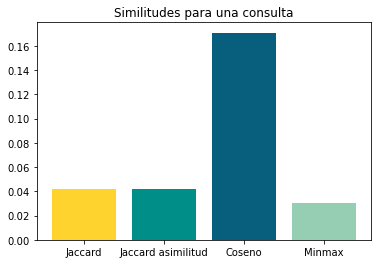

In [ ]:
x=['Jaccard','Jaccard asimilitud','Coseno','Minmax']
y=[doc_max_sim_jac, doc_max_sim_asim, doc_max_sim_cos,doc_max_sim_minmax]
colores=['#FFD32D','#008E89','#085E7D','#96CEB4']
plt.bar(x,y, color=colores)
plt.title("Similitudes para una consulta")

## Conclusiones

Después implementar la búsqueda de pares similares por Índice Inverso y realizar el análisis correspondiente podemos concluir que;

- El índice inverso ciertamente muestra ser rápido al realizar una query sobre un conjunto de documentos, misma razón por la cual el índice inverso da pauta a motores de búsqueda. Más aún, esto posee ventajas no sólo temporales, sino espaciales, pues el índice inverso también permite minimizar la memoria empleada. 

- Usando el indice inverso reduce el número de comparaciones para la busqueda de documentos similares y ofrece una forma eficiente de busqueda.

- Además de documentos similares el indice puede expandirse a images con el mismo objetivo.

- Algunas otras aplicaciones pueden ser plagio en documentos escolares, articulos del mismo autor en diferentes fuentes, recomendación de articulos a traves de gustos similares. 

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=d81fae23-b603-4c9f-a096-b0bc7cb11e2a' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>